Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal number of topics 4


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joramas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


>  Art and Science - Technology in Museum'
> 20th century history and current events of interest to you
> 2019 Olympics in Tokyo
>  Sports and Outdoors


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

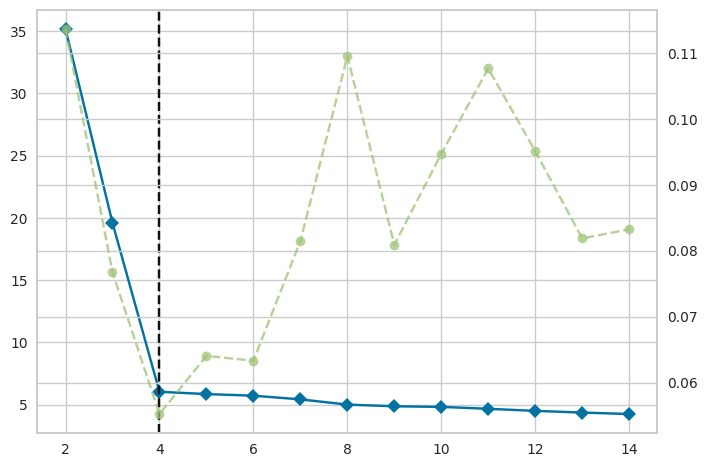

In [1]:
from pipeline.topic_model.k_means_llm import TopicModel
sentences = [f"This is a sentence about sports cycling basket running football {i}" for i in range(1, 26)] + \
            [f"This is a sentence about politics dialogue elections {i}"for i in range(1, 26)] + \
            [f"This is a sentence about technology AI, math, universities {i}"for i in range(1, 26)] + \
            [f"This is a sentence about art painting, museums and music {i}"for i in range(1, 26)]

tm = TopicModel()
    
topics = tm.get_topics(sentences)


### Load LLM model

In [11]:
from ctransformers import AutoModelForCausalLM

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
llm = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF", 
    model_file="/run/media/joramas/DATA/THESIS/playground/models/mistral-7b-instruct-v0.1.Q5_K_M.gguf", 
    model_type="mistral", 
    gpu_layers=30)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 9118.05it/s]
Fetching 0 files: 0it [00:00, ?it/s]


: 

: 

# Load Documents

In [1]:
from pipeline.doc_load.document_loader import multi_xscience_get_text

train, test, val = multi_xscience_get_text()

# Summarize single Document

# Embed summaries

In [2]:
from pipeline.embedding.basic_embeddings import Embedding

embedding_model = Embedding(model=llm)

embeddings = []
for item in test[0]:
    embedded_item = []
    for key,value in item.items():
        embedded_item.append(embedding_model.embed(value))
    embeddings.append(embedded_item)

/home/joramas/miniconda/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Store Embeddings in Vector DB

In [28]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct, Batch
from qdrant_client.models import Distance, VectorParams

client =  QdrantClient(host="localhost", port=6333)


testcase_no = 0
for it in embeddings:
    testcase_no += 1
    
    client.recreate_collection(
        collection_name=testcase_no,
        vectors_config=VectorParams(size=384, distance=Distance.COSINE)
    )
    
    # points = [] 
    # for i,v in enumerate(it):
    #     points.append(PointStruct(
    #         # TODO here goes the document internal ID for citations
    #         id=i,
            
    #         vector=v[0].tolist(),
    #         payload={"color": "red"}
    #         )
    #     )

    print("a", list(i[0].tolist() for i in it[0:1])[0])
    break
    # client.upsert(
    #     collection_name=testcase_no, 
    #     points=Batch(
    #         ids=[i for i in range(0,len(it))],
    #         vectors = [v[0].tolist() for v in it]
    #     )
    # )
# del embeddings


a [-0.14483502507209778, -0.03582286089658737, -0.06889834254980087, 0.014420847408473492, 0.022147424519062042, 0.006996339652687311, 0.07733961939811707, 0.06251576542854309, -0.008446167223155499, -0.058855634182691574, -0.018602246418595314, -0.06078525632619858, 0.0006669876165688038, -0.029963603243231773, -0.05252508446574211, -0.019529523327946663, -0.025233961641788483, -0.060558803379535675, -0.10995238274335861, 0.0024385442957282066, -0.004154846537858248, -0.013413692824542522, -0.11040470004081726, -0.05190467834472656, -0.0556841604411602, -0.07026683539152145, -0.038701336830854416, 0.07620805501937866, 0.0007678027614019811, -0.04752758517861366, 0.015403478406369686, 0.0018796473741531372, 0.03871352598071098, 0.09355969727039337, 0.040638890117406845, -0.018005941063165665, -0.018026817589998245, 0.036752909421920776, -0.045180365443229675, 0.06520835310220718, 0.009808385744690895, 0.027005407959222794, 0.04481270909309387, -0.0240474883466959, 0.03303472697734833, 

### control plot for embedding visualization

In [37]:
import random
# from qdrant_client import QdrantClient
# from qdrant_client.models import PointStruct
# from qdrant_client.models import Distance, VectorParams

# client =  QdrantClient(host="localhost", port=6333)

# query_id = random.randint(0,len(train[0]))
query_id = random.randint(1,2)
# # collection = client.get_collection(collection_name=query_id)
# vectors_ids = client.search(collection_name=query_id, query_vector=[-9.0]*384)
# vectors = client.retrieve(collection_name=query_id, ids = [i.id for i in vectors_ids])
vectors = embeddings[query_id]


In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10)
plt.title('2D Plot of Vector Database Collection')
plt.grid(True)

ValueError: Found array with dim 4. PCA expected <= 2.

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# Assuming vector_collection is a list of high-dimensional vectors
# Example:
# vector_collection = [[x1, x2, x3, ..., xn], [y1, y2, y3, ..., yn], ...]

# Convert the vector collection to a numpy array
vector_collection = np.array(vectors)

# Perform PCA to reduce the vectors to 3D
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vector_collection)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the x, y, and z components from the reduced vectors
x = vectors_3d[:, 0]
y = vectors_3d[:, 1]
z = vectors_3d[:, 2]

# Create the scatter plot
ax.scatter(x, y, z, c='b', marker='o', s=30)

# Set labels for the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set a title for the plot
ax.set_title('3D Plot of High-Dimensional Vector Collection (PCA)')

# Show the plot
plt.show()


ValueError: Found array with dim 3. PCA expected <= 2.

# Detect Topics

# Find Relevant embeddings

# Join semanticallly

# Abstract summary of Relevant Documents

### Loading LLM

/home/joramas/miniconda/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 9845.78it/s]
Fetching 0 files: 0it [00:00, ?it/s]


In [3]:
# control prompt
llm("Q: Who are you?")

"\nA: I'm Mistral, a language model trained by the Mistral AI team."

In [10]:
tokens = llm.tokenize("prompt: Hi, can you explain what are your main purposes\n")
generated = llm.generate(tokens)
llm.detokenize(list(generated))

"prompt: Hello, my purpose is to help people find information and answer their questions. I'm designed to be a useful assistant for anyone who needs help with anything from finding recipes to getting homework done. I aim to be helpful, accurate, and efficient in providing the information or assistance that people need. Is there anything else you would like to know?"